# **AI201 - Programming Assignment #1**
#### *Implementing the A* Algorithm*

Instructor: Dr. Pros Naval

Submitted by: Geyzson Kristoffer

October 21, 2023

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import clear_output
import time
from icecream import ic
import heapq
import time

In [89]:
# reading the file
def read_states(file_path):

    initial_state = []
    goal_state = []
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
        start_index = lines.index("start\n") + 1 
        goal_index = lines.index("goal\n") + 1 
        
        for i in range(start_index, start_index + 3):
            row = lines[i].strip().split(" ")
            initial_state.append([int(x) if x != '*' else '*' for x in row])
        
        for i in range(goal_index, goal_index + 3):
            row = lines[i].strip().split(" ")
            goal_state.append([int(x) if x != '*' else '*' for x in row])
            
    return np.array(initial_state).flatten(), np.array(goal_state).flatten()

file_path = "astar_in.txt"  
initial_state, goal_state = read_states(file_path)
initial_state, goal_state

(array(['2', '1', '6', '4', '*', '8', '7', '5', '3'], dtype='<U11'),
 array(['1', '2', '3', '8', '*', '4', '7', '6', '5'], dtype='<U11'))

In [90]:
def wrong_count(state, goal_state):
    node = np.array(state).copy()
    gs = np.array(goal_state).copy()
    return sum([1 for i in range(len(node)) if ((node[i] != gs[i]) and (node[i] != '*'))])

def manhattan_distance(state, goal_state):

    md_list = []
    node = np.array(state).copy().reshape(3, 3)
    gs = np.array(goal_state).copy().reshape(3, 3)

    for i in range(len(node[0])):
        for j in range(len(node[1])):
            if node[i][j] == '*':
                md_list.append(0)
                continue
            else:
                row, col = np.where(gs == node[i][j])
                md_list.append(abs(col[0]-j) + abs(row[0]-i))


    return sum(md_list)

def sequence_score(state, goal_state):
    node = np.array(state).copy().reshape(3, 3)
    # gs = deepcopy(goal_state).reshape(3, 3)

    node_sequence = [
        node[0, 0], node[0, 1], node[0, 2],
        node[1, 2], node[2, 2], node[2, 1],
        node[2, 0], node[1, 0]
    ]
    
    actual_next = node_sequence[1:]
    actual_next.extend([node_sequence[0]])

    goal_next = [str(int(tile)+1) if tile != '*' else None for tile in node_sequence]

    try:
        goal_next[goal_next.index('9')] = '1'
    except ValueError:
        pass

    sequence_score = 0
    sequence_score = sum([2 for i in range(len(goal_next)) if (goal_next[i] != actual_next[i]) and (goal_next[i] != None)])

    if node[1, 1] != '*':
        sequence_score += 1

    return sequence_score


In [91]:
# returns the state moved in a direction
def move(state, direction):

    node = np.array(state).copy().reshape(3, 3)
    directions = {
        'up': (-1, 0),
        'down': (1, 0),
        'left': (0, -1),
        'right': (0, 1)
    }

    row_change, col_change = directions.get(direction, (0, 0))
    new_state = deepcopy(node)

    star_index = np.where(node == '*')

    r, c = star_index[0][0], star_index[1][0]
    
    # if within the bounds
    if (0 <= r + row_change < len(new_state)) and (0 <= c + col_change < len(new_state[0])):
        new_state[r][c], new_state[r + row_change][c + col_change] = new_state[r + row_change][c + col_change], new_state[r][c]
        return np.array(new_state).flatten()
    else:
        return None 

In [106]:
# store as tuple, evaluate as array
def astar(initial_state, goal_state, heuristic='sequence_score', max_iterations=6969):

    time_start = time.time()

    open_list = []
    closed_list = []
    parent_list = {}
    g_values = {}
    f_values = {}
    wc_values = {}
    P_values = {}
    S_values = {}
    path = []
    explored_states = set()
    search_cost = 0
    
    f, g, wc, P, S = 0, 0, 0, 0, 0

    if heuristic == 'wrong_count':
        wc = wrong_count(initial_state, goal_state)
        f += wc
    elif heuristic == 'manhattan_distance':
        P = manhattan_distance(initial_state, goal_state)
        f += P
    elif heuristic == 'sequence_score':
        P = manhattan_distance(initial_state, goal_state)
        S = sequence_score(initial_state, goal_state)
        f += P + 3*S

    
    IS_tuple = tuple(initial_state)
    GS_tuple = tuple(goal_state)

    # store values
    f_values[IS_tuple] = f
    g_values[IS_tuple] = g
    wc_values[IS_tuple] = wc
    P_values[IS_tuple] = P
    S_values[IS_tuple] = S

    # add on explored states
    explored_states.add(IS_tuple)
    parent_list[IS_tuple] = None

    heapq.heappush(open_list, (f, IS_tuple, g, wc, P, S))

    for i in range(max_iterations):

        if len(open_list) == 0:
            time_end = time.time()
            print('heuristic: ', heuristic, '')
            print("Time taken in milliseconds: ", (time_end - time_start)*1000)
            print("No solution found")
            return None
        
        f_value, n, g, wc, P, S = heapq.heappop(open_list)
        search_cost += 1

        heapq.heappush(closed_list, (f_value, n, g, wc, P, S))

        if n == GS_tuple:
            time_end = time.time()
            print('heuristic: ', heuristic, '')
            print("Time taken in milliseconds: ", (time_end - time_start)*1000)
            print("Goal state found")

            while parent_list[n] is not None:
                path.append(n)
                n = parent_list[n]

            path.append(IS_tuple)

            ic(search_cost)

            return {
                'path': path[::-1],
                'f_values': f_values,
                'g_values': g_values,
                'wc_values': wc_values,
                'P_values': P_values,
                'S_values': S_values,
                'parent_list': parent_list,
                'explored_states': explored_states,
                'search_cost': search_cost
            }

        
        successors = [move(n, 'up'), move(n, 'down'), move(n, 'left'), move(n, 'right')]

        for node in successors:
            if node is not None:
                node_tuple = tuple(node.flatten())
                if node_tuple not in explored_states:
                    explored_states.add(node_tuple)
                    parent_list[node_tuple] = n

                    g_values[node_tuple] = g_values[n] + 1
                    wc_values[node_tuple] = wrong_count(node_tuple, goal_state)
                    P_values[node_tuple] = manhattan_distance(node_tuple, goal_state)
                    S_values[node_tuple] = sequence_score(node_tuple, goal_state)
                    f_values[node_tuple] = g_values[node_tuple] + P_values[node_tuple] + 3*S_values[node_tuple]

                    if heuristic == 'wrong_count':
                        f_values[node_tuple] = g_values[node_tuple] + wc_values[node_tuple]
                    elif heuristic == 'manhattan_distance':
                        f_values[node_tuple] = g_values[node_tuple] + P_values[node_tuple]
                    elif heuristic == 'sequence_score':
                        f_values[node_tuple] = g_values[node_tuple] + P_values[node_tuple] + 3*S_values[node_tuple]

                    heapq.heappush(open_list, (f_values[node_tuple], node_tuple, g_values[node_tuple], wc_values[node_tuple], P_values[node_tuple], S_values[node_tuple]))  
 


                elif node_tuple in explored_states:
                    if g_values[node_tuple] > g_values[n] + 1:
                        g_values[node_tuple] = g_values[n] + 1
                        parent_list[node_tuple] = n

                        if heuristic == 'wrong_count':
                            f_values[node_tuple] = g_values[node_tuple] + wc_values[node_tuple]
                        elif heuristic == 'manhattan_distance':
                            f_values[node_tuple] = g_values[node_tuple] + P_values[node_tuple]
                        elif heuristic == 'sequence_score':
                            f_values[node_tuple] = g_values[node_tuple] + P_values[node_tuple] + 3*S_values[node_tuple]

                        heapq.heappush(open_list, (f_values[node_tuple], node_tuple, g_values[node_tuple], wc_values[node_tuple], P_values[node_tuple], S_values[node_tuple]))

                        
            elif node is None:
                pass


    return {
        'path': path[::-1],
        'f_values': f_values,
        'g_values': g_values,
        'wc_values': wc_values,
        'P_values': P_values,
        'S_values': S_values,
        'parent_list': parent_list,
        'explored_states': explored_states,
        'search_cost': search_cost
    }

result = astar(initial_state, goal_state, heuristic='sequence_score')

path = result['path']
f_values = result['f_values']
g_values = result['g_values']
parent_list = result['parent_list']
explored_states = result['explored_states']
search_cost = result['search_cost']

ic| search_cost: 42


heuristic:  sequence_score 
Time taken in milliseconds:  1.0013580322265625
Goal state found


In [102]:
path

[('2', '1', '6', '4', '*', '8', '7', '5', '3'),
 ('2', '1', '6', '4', '8', '*', '7', '5', '3'),
 ('2', '1', '*', '4', '8', '6', '7', '5', '3'),
 ('2', '*', '1', '4', '8', '6', '7', '5', '3'),
 ('2', '8', '1', '4', '*', '6', '7', '5', '3'),
 ('2', '8', '1', '4', '6', '*', '7', '5', '3'),
 ('2', '8', '1', '4', '6', '3', '7', '5', '*'),
 ('2', '8', '1', '4', '6', '3', '7', '*', '5'),
 ('2', '8', '1', '4', '*', '3', '7', '6', '5'),
 ('2', '8', '1', '*', '4', '3', '7', '6', '5'),
 ('*', '8', '1', '2', '4', '3', '7', '6', '5'),
 ('8', '*', '1', '2', '4', '3', '7', '6', '5'),
 ('8', '1', '*', '2', '4', '3', '7', '6', '5'),
 ('8', '1', '3', '2', '4', '*', '7', '6', '5'),
 ('8', '1', '3', '2', '*', '4', '7', '6', '5'),
 ('8', '1', '3', '*', '2', '4', '7', '6', '5'),
 ('*', '1', '3', '8', '2', '4', '7', '6', '5'),
 ('1', '*', '3', '8', '2', '4', '7', '6', '5'),
 ('1', '2', '3', '8', '*', '4', '7', '6', '5')]

In [104]:
# for rendering purposes
def render_puzzle(state, clear_prev=False):

    state = np.array(state).copy().reshape(3, 3)
    if clear_prev:
        clear_output(wait=True)

    fig, ax = plt.subplots(figsize=(8, 8))
    
    empty_tile_color = 'black'
    ax.set_facecolor(empty_tile_color)
    
    border_thickness = 0.05
    cell_size = 1 - 2 * border_thickness

    for i in range(3):
        for j in range(3):
            cell_value = state[i, j]
            if cell_value == '*':
                face_color = empty_tile_color
                text_color = empty_tile_color
            else:
                face_color = 'white'
                text_color = 'black'
            
            ax.add_patch(plt.Rectangle((j + border_thickness, 2 - i + border_thickness), cell_size, cell_size, facecolor=face_color, edgecolor=empty_tile_color, linewidth=2*border_thickness))
            ax.text(j + 0.5, 2 - i + 0.5, str(cell_value), size=20, ha='center', va='center', color=text_color)

    plt.title("8 Puzzle AI using A*", fontsize=16, fontweight='bold', pad=20)
    ax.text(1.5, 3.05, "Geyzson Kristoffer", ha='center', va='center', fontsize=10, fontstyle='italic')


    plt.xlim(0, 3)
    plt.ylim(0, 3)
    ax.set_aspect('equal', 'box')
    ax.axis('off')
    plt.show()

def animate_path(path, f_values, g_values, wc_values, P_values, S_values):

    time.sleep(1)
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.text(0.5, 0.65, "Goal Reached", ha='center', va='center', fontsize=24, fontweight='bold')
    ax.text(0.5, 0.5, "Replaying the best path in", ha='center', va='center', fontsize=16)
    ax.axis('off')
    plt.show()
    time.sleep(2)  # wait for 2 seconds

    # 3-second countdown
    for count in range(3, 0, -1):
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.text(0.5, 0.5, str(count), ha='center', va='center', fontsize=60, fontweight='bold')
        ax.axis('off')
        plt.show()
        time.sleep(1)  # wait for 1 second

    # play the animation
    for node in path:
            node_tuple = tuple(node)

            # Print the values for the current node:

            render_puzzle(np.array(node).reshape(3, 3), clear_prev=True)
            # print(f"f: {f_values[node_tuple]}, g: {g_values[node_tuple]}, wc: {wc_values[node_tuple]}, P: {P_values[node_tuple]}, S: {S_values[node_tuple]}")
            # use ic to print the values for the current node
            ic(f_values[node_tuple], g_values[node_tuple], wc_values[node_tuple], P_values[node_tuple], S_values[node_tuple])


            time.sleep(0.5)

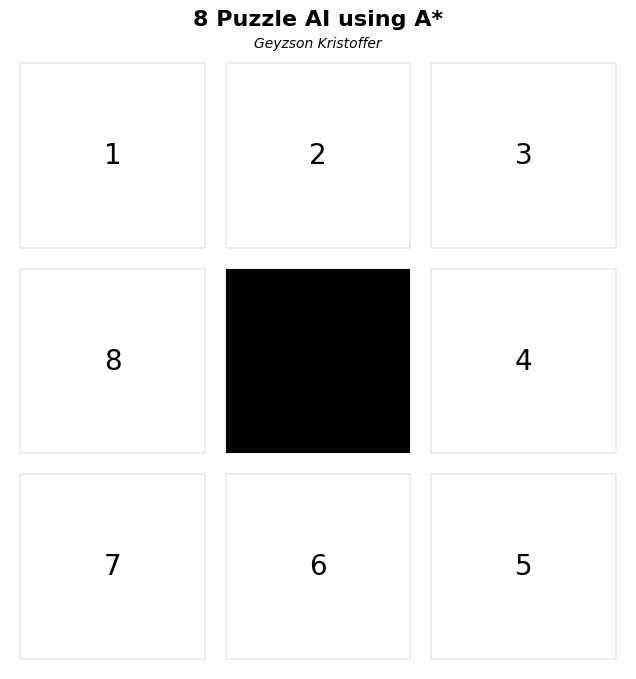

ic| f_values[node_tuple]: 18
    g_values[node_tuple]: 18
    wc_values[node_tuple]: 0
    P_values[node_tuple]: 0
    S_values[node_tuple]: 0


Search cost:  42


In [108]:
animate_path(path, f_values, g_values, result['wc_values'], result['P_values'], result['S_values'])
print("Search cost: ", search_cost)